# Test Case: Deep Learning

In [19]:
#imports
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import datetime
import shap
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/Users/dgtzm99/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check tensorflow version
!python -c 'import tensorflow as tf; print(tf.__version__)'

2.0.0


In [3]:
# check keras version
!python -c 'import keras as k; print(k.__version__)'

Using TensorFlow backend.
2.3.1


In [4]:
# Stock Variables
ASSET = 'BTC'
START = '2012-01-01'
END = '2021-12-17'
YRS = 2
TRAIN_LEN = 0.8 # 80%
TIME_STEPS = 15

# Get data

In [5]:
# data = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', 
#                       end='2019-12-17')
today = datetime.date.today()
data = web.get_data_yahoo([ASSET + '-USD'], 
                         start=datetime.datetime(today.year-YRS
                                                 , 1, 1), 
                         end=today)#['Close']

data.tail()

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2022-03-22,42358.808594,42358.808594,43124.707031,40948.281250,41074.105469,32004652376
2022-03-23,42892.957031,42892.957031,42893.507812,41877.507812,42364.378906,25242943069
2022-03-24,43960.933594,43960.933594,44131.855469,42726.164062,42886.652344,31042992291
2022-03-25,44348.730469,44348.730469,44999.492188,43706.285156,43964.546875,30574413034
2022-03-26,44399.074219,44399.074219,44531.281250,44168.675781,44334.335938,16318618624


In [6]:
# Deleting Symbol header Column names
data = data.droplevel(level=1, axis=1)

In [8]:
# Getting data summary
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 816 entries, 2020-01-01 to 2022-03-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  816 non-null    float64
 1   Close      816 non-null    float64
 2   High       816 non-null    float64
 3   Low        816 non-null    float64
 4   Open       816 non-null    float64
 5   Volume     816 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 44.6 KB


# Normalize the data
Normalizing is usually used since LSTM is sensitive to magnitude in the dataset

Which is better?
- Standard scaler
- MinMaxScaler
- Normalize

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(data)
data_scaled = scaler.transform(data)
pd.DataFrame(data_scaled).tail()

,0,1,2,3,4,5
811,0.626363,0.626363,0.609615,0.619961,0.560259,-0.331681
812,0.654512,0.654512,0.597754,0.670459,0.628191,-0.667497
813,0.710792,0.710792,0.661288,0.716578,0.655689,-0.379441
814,0.731228,0.731228,0.705803,0.769842,0.712439,-0.402713
815,0.733881,0.733881,0.681781,0.794970,0.731908,-1.110718


In [10]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
data_scaled = scaler.fit_transform(data)
pd.DataFrame(data_scaled).tail()

,0,1,2,3,4,5
811,0.597291,0.597291,0.595559,0.591590,0.576709,0.058315
812,0.605824,0.605824,0.591916,0.606511,0.597338,0.038352
813,0.622885,0.622885,0.611430,0.620139,0.605688,0.055475
814,0.629080,0.629080,0.625103,0.635877,0.622922,0.054092
815,0.629885,0.629885,0.617725,0.643302,0.628834,0.012004


# Reshape data for LSTM
We reshape input as `(n_samples, timesteps, n_features)`

In [11]:
# originial shape [n_samples, n_features]
data_scaled.shape

(816, 6)

In [12]:
X_train = []
y_train = []

n_future = 1 # number of day we look into the future
# We are predicting Close price
target = 1 # Close col

for i in range(TIME_STEPS, data_scaled.shape[0] - n_future +1):
    X_train.append(data_scaled[i - TIME_STEPS:i, 0:data_scaled.shape[1]])
    y_train.append(data_scaled[i + n_future - 1:i + n_future, target])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
# Keep in mind n_samples gets reduced due to the TIME_STEPS
print('X_train shape = ', X_train.shape) 
print('y_train shape = ', y_train.shape)

X_train shape =  (801, 15, 6)
y_train shape =  (801, 1)


# Fit LSTM model

In [14]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], 
                            X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

2022-03-26 18:45:14.308844: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-26 18:45:14.310381: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15, 64)            18176     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [15]:
# fit the model
history = model.fit(X_train, y_train, epochs=5, batch_size=16, 
                    validation_split=0.1, verbose=1)

Train on 720 samples, validate on 81 samples
Epoch 1/5
720/720 [==============================] - 5s 7ms/step - loss: 0.0284 - val_loss: 0.0048
Epoch 2/5
720/720 [==============================] - 3s 4ms/step - loss: 0.0099 - val_loss: 0.0033
Epoch 3/5
720/720 [==============================] - 3s 4ms/step - loss: 0.0081 - val_loss: 0.0043
Epoch 4/5
720/720 [==============================] - 3s 4ms/step - loss: 0.0080 - val_loss: 0.0026
Epoch 5/5
720/720 [==============================] - 3s 4ms/step - loss: 0.0080 - val_loss: 0.0020


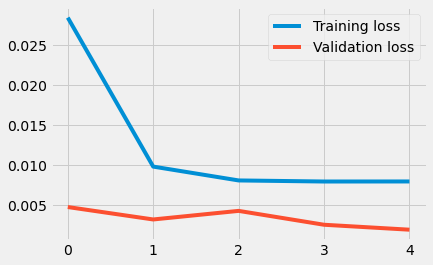

In [16]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

# Make predictions

Here we take the Keras model trained above and explain why it makes different predictions for different individuals. SHAP expects model functions to take a 2D numpy array as input, so we define a wrapper function around the original Keras predict function.

In [23]:
def f(X):
    return model.predict([X[:,i] for i in range(X.shape[1])]).flatten()

In [24]:
explainer = shap.KernelExplainer(f, X_train[:50,:])
shap_values = explainer.shap_values(X_train[299,:], nsamples=500)

Provided model function fails when applied to the provided data set.


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 15 arrays: [array([[0.03561545, 0.03561545, 0.03029567, 0.0492647 , 0.03505058,
        0.01863826],
       [0.03218546, 0.03218546, 0.02963105, 0.04541606, 0.03517303,
        0.02524091],
       [0.03792726, 0...

In [115]:
#Make prediction
n_days_for_prediction = TIME_STEPS
prediction = model.predict(X_train[-n_days_for_prediction:]) 
#shape = (n, 1) where n is the n_days_for_prediction

## Perform inverse transform to get back the original data

In [122]:
n_past = 17
train_dates = pd.to_datetime(data.index)
predict_period_dates = pd.date_range(list(train_dates)[-n_past], 
                    periods=n_days_for_prediction, freq=us_bd).tolist()
prediction_copies = np.repeat(prediction, data_scaled.shape[1], 
                              axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [129]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

/Users/dgtzm99/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/dgtzm99/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Date', ylabel='Close'>

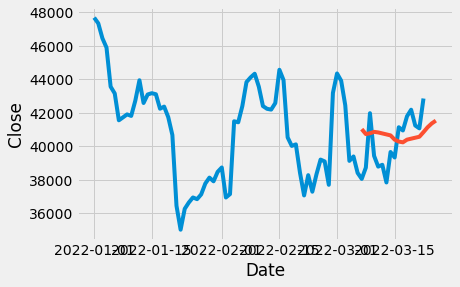

In [137]:
import seaborn as sns
original = data['Close']
#original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original.index >= '2022-1-1']

sns.lineplot(original.index, original)
sns.lineplot(df_forecast['Date'], df_forecast['Close'])

In [150]:
from keras.datasets import imdb
from keras.preprocessing import sequence
max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


/Users/dgtzm99/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/keras/datasets/imdb.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/dgtzm99/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/keras/datasets/imdb.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [151]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

Pad sequences (samples x time)


In [154]:
pd.DataFrame(x_train)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,15,256,4,2,7,3766,5,723,36,71,...,4472,113,103,32,15,16,5345,19,178,32
1,125,68,2,6853,15,349,165,4362,98,5,...,52,154,462,33,89,78,285,16,145,95
2,645,662,8,257,85,1200,42,1228,2578,83,...,106,607,624,35,534,6,227,7,129,113
3,2,14,280,13,219,4,2,431,758,859,...,26,49,7008,15,566,30,579,21,64,2574
4,56,429,6,1513,18,35,534,95,474,570,...,19,14,5,7224,6,226,251,7,61,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,15,172,136,4,8827,4322,613,9,6,147,...,5412,198,646,196,17,25,2537,12,17,1219
24996,4679,140,143,134,2,8,79,27,1484,13,...,7562,13,482,15,5902,2568,4,359,18,2
24997,529,443,17793,5,27,710,117,2,8123,165,...,1006,541,9303,7,4,59,11027,4,3586,2
24998,286,1814,23,4,123,13,161,40,5,421,...,5,2,12,38,84,80,124,12,9,23
